In [89]:
import boto3
import os
import json
from uuid import uuid4
from IPython.display import Image

In [2]:
sns_client = boto3.client("sns")

In [3]:
sqs_client = boto3.client("sqs")

In [4]:
s3_client = boto3.client("s3")

In [5]:
queue_name = "same-story-check-queue"
topic_name = "same-story-check-topic"

In [6]:
queue_url = "https://us-west-2.queue.amazonaws.com/163803973373/same-story-check-queue"
queue_arn = "arn:aws:sqs:us-west-2:163803973373:same-story-check-queue"

In [7]:
topic_arn = "arn:aws:sns:us-west-2:163803973373:same-story-check-topic"

In [8]:
subscription_arn = "arn:aws:sns:us-west-2:163803973373:same-story-check-topic:919203cd-bbbd-4a14-b997-706063f7fd12"

In [9]:
queue_permission_name = f"{topic_name}-send"

In [10]:
visibility_timeout = 60 * 5 # how long the backend has to process each job

### Create the SQS queue

In [7]:
d = sqs_client.create_queue(
    QueueName=queue_name,
    Attributes={
        "VisibilityTimeout": str(visibility_timeout)
    }
); d

{'QueueUrl': 'https://us-west-2.queue.amazonaws.com/163803973373/same-story-check-queue',
 'ResponseMetadata': {'RequestId': '77f1dcb7-4057-514d-899f-861ea11801e2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '77f1dcb7-4057-514d-899f-861ea11801e2',
   'date': 'Tue, 15 Mar 2022 00:34:23 GMT',
   'content-type': 'text/xml',
   'content-length': '344'},
  'RetryAttempts': 0}}

In [11]:
queue_url = d["QueueUrl"]; queue_url

'https://us-west-2.queue.amazonaws.com/163803973373/same-story-check-queue'

In [13]:
d = sqs_client.get_queue_attributes(QueueUrl=queue_url, AttributeNames=["QueueArn"])

In [18]:
queue_arn = d["Attributes"]["QueueArn"]; queue_arn

'arn:aws:sqs:us-west-2:163803973373:same-story-check-queue'

#### Set the visibility timeout after the queue has been created

In [96]:
sqs_client.set_queue_attributes(
    QueueUrl=queue_url,
    Attributes={
        "VisibilityTimeout": str(visibility_timeout)
    }
)

{'ResponseMetadata': {'RequestId': '0ff0f20a-5a50-58f9-a298-a8bf02fab933',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0ff0f20a-5a50-58f9-a298-a8bf02fab933',
   'date': 'Wed, 23 Mar 2022 17:18:34 GMT',
   'content-type': 'text/xml',
   'content-length': '225'},
  'RetryAttempts': 0}}

In [14]:
sqs_client.get_queue_attributes(
    QueueUrl=queue_url,
    AttributeNames=[
        "VisibilityTimeout"
    ]
)

{'Attributes': {'VisibilityTimeout': '120'},
 'ResponseMetadata': {'RequestId': '8ce83d16-767e-5d88-ada4-67b8d6c13aa0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8ce83d16-767e-5d88-ada4-67b8d6c13aa0',
   'date': 'Fri, 18 Mar 2022 15:00:15 GMT',
   'content-type': 'text/xml',
   'content-length': '349'},
  'RetryAttempts': 0}}

### Create the SNS topic

In [9]:
d = sns_client.create_topic(Name=topic_name); d

{'TopicArn': 'arn:aws:sns:us-west-2:163803973373:same-story-check-topic',
 'ResponseMetadata': {'RequestId': '02c6f2e9-4ecf-582e-8387-a843869bc224',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '02c6f2e9-4ecf-582e-8387-a843869bc224',
   'content-type': 'text/xml',
   'content-length': '329',
   'date': 'Tue, 15 Mar 2022 17:00:04 GMT'},
  'RetryAttempts': 0}}

In [10]:
topic_arn = d["TopicArn"]

In [12]:
sns_client.list_topics()

{'Topics': [{'TopicArn': 'arn:aws:sns:us-west-2:163803973373:engi-newsletter'},
  {'TopicArn': 'arn:aws:sns:us-west-2:163803973373:same-story-check-topic'}],
 'ResponseMetadata': {'RequestId': '54c81737-ceb3-5ff3-b03c-4d9d0600a87a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '54c81737-ceb3-5ff3-b03c-4d9d0600a87a',
   'content-type': 'text/xml',
   'content-length': '498',
   'date': 'Tue, 15 Mar 2022 17:01:39 GMT'},
  'RetryAttempts': 0}}

### Connect SNS to SQS

In [13]:
r = sns_client.subscribe(
    TopicArn=topic_arn,
    Protocol="sqs",
    Endpoint=queue_arn,
    ReturnSubscriptionArn=True
); r

{'SubscriptionArn': 'arn:aws:sns:us-west-2:163803973373:same-story-check-topic:919203cd-bbbd-4a14-b997-706063f7fd12',
 'ResponseMetadata': {'RequestId': '6561536f-55f1-5a3f-98cc-09c59d009f31',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6561536f-55f1-5a3f-98cc-09c59d009f31',
   'content-type': 'text/xml',
   'content-length': '372',
   'date': 'Tue, 15 Mar 2022 17:02:40 GMT'},
  'RetryAttempts': 0}}

### Set the permissions on the queue

In [31]:
def allow_sns_to_write_to_sqs(topic_arn, queue_arn):
    return """{{
  "Version":"2012-10-17",
  "Statement":[
    {{
      "Sid":"MyPolicy",
      "Effect":"Allow",
      "Principal" : {{"AWS" : "*"}},
      "Action":"SQS:SendMessage",
      "Resource": "{}",
      "Condition":{{
        "ArnEquals":{{
          "aws:SourceArn": "{}"
        }}
      }}
    }}
  ]
}}""".format(queue_arn, topic_arn)

'{\n  "Version":"2012-10-17",\n  "Statement":[\n    {\n      "Sid":"MyPolicy",\n      "Effect":"Allow",\n      "Principal" : {"AWS" : "*"},\n      "Action":"SQS:SendMessage",\n      "Resource": "arn:aws:sqs:us-west-2:163803973373:same-story-check-queue",\n      "Condition":{\n        "ArnEquals":{\n          "aws:SourceArn": "arn:aws:sns:us-west-2:163803973373:same-story-check-topic"\n        }\n      }\n    }\n  ]\n}'

In [33]:
r = sqs_client.set_queue_attributes(
    QueueUrl = queue_url,
    Attributes = {
        'Policy' : allow_sns_to_write_to_sqs(topic_arn, queue_arn)
    }
); r

{'ResponseMetadata': {'RequestId': 'd07426b9-a809-5c42-877f-7c137cf83c15',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd07426b9-a809-5c42-877f-7c137cf83c15',
   'date': 'Tue, 15 Mar 2022 17:53:53 GMT',
   'content-type': 'text/xml',
   'content-length': '225'},
  'RetryAttempts': 0}}

In [ ]:
# seems to hang for some reason!
r = sqs_client.add_permission(
    QueueUrl=queue_url,
    Label=queue_permission_name,
    AWSAccountIds=[
        os.environ["AWS_ACCESS_KEY_ID"],
    ],
    Actions=[
        "SendMessage", "DeleteMessage",
    ]
); r

In [34]:
r = sqs_client.get_queue_attributes(
    QueueUrl=queue_url,
    AttributeNames=[
        'Policy',
    ]
); r

{'Attributes': {'Policy': '{"Version":"2012-10-17","Statement":[{"Sid":"MyPolicy","Effect":"Allow","Principal":{"AWS":"*"},"Action":"SQS:SendMessage","Resource":"arn:aws:sqs:us-west-2:163803973373:same-story-check-queue","Condition":{"ArnEquals":{"aws:SourceArn":"arn:aws:sns:us-west-2:163803973373:same-story-check-topic"}}}]}'},
 'ResponseMetadata': {'RequestId': '66b43bcd-fec4-56ce-acda-61672a392699',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '66b43bcd-fec4-56ce-acda-61672a392699',
   'date': 'Tue, 15 Mar 2022 17:54:05 GMT',
   'content-type': 'text/xml',
   'content-length': '815'},
  'RetryAttempts': 0}}

### Publish a message to the SNS topic

In [13]:
d = {
 'check': 1644302997171,
 'width': '800',
 'height': '600',
 'component': 'Button',
 'story': 'Primary',
 'repository': 'engi-network/engi-ui'}

In [63]:
from uuid import uuid4

In [68]:
check_id = 1644302997171
check_id = str(uuid4())
d = {
    "check_id": check_id
}

### Copy files in S3 to mock a job request

In [115]:
test_check_id = "testing-source"
ids = [test_check_id]

In [102]:
ids = []
for i in range(1):
    check_id = str(uuid4())
    ids.append(check_id)
    !aws s3 cp --recursive --exclude "report/*" s3://same-story/checks/1644302997171/ s3://same-story/checks/{check_id}
    sns_client.publish(
        TopicArn=topic_arn,
        Message=json.dumps({"check_id": check_id}),
    )

copy: s3://same-story/checks/1644302997171/frames/Button-Primary.png to s3://same-story/checks/5a8c2362-df9a-461e-a1ea-855bd0ab4d3a/frames/Button-Primary.png
copy: s3://same-story/checks/1644302997171/specification.json to s3://same-story/checks/5a8c2362-df9a-461e-a1ea-855bd0ab4d3a/specification.json


In [132]:
sns_client.publish(
    TopicArn=topic_arn,
    Message=json.dumps({"check_id": test_check_id}),
)

{'MessageId': 'bff2fe8a-a090-5242-b9b8-a43d7f48c32c',
 'ResponseMetadata': {'RequestId': 'f4404f29-4fe2-54c9-bf38-159e903a25a7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f4404f29-4fe2-54c9-bf38-159e903a25a7',
   'content-type': 'text/xml',
   'content-length': '294',
   'date': 'Fri, 25 Mar 2022 15:19:51 GMT'},
  'RetryAttempts': 0}}

In [210]:
ids = [test_check_id]
ids = [1644302997171]
ids = ["293bdbd6-dee7-4e17-b3db-82765db6308f"]

In [211]:
for check_id in ids:
    !aws s3 ls s3://same-story/checks/{check_id}/ --recursive --human-readable --summarize

2022-03-29 09:40:38    9.5 KiB checks/293bdbd6-dee7-4e17-b3db-82765db6308f/frames/Button-Primary.png
2022-03-29 09:43:01    4.9 KiB checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/__screenshots__/Example/Button/Primary.png
2022-03-29 09:43:01    5.2 KiB checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/__screenshots__/Example/Button/Secondary.png
2022-03-29 09:43:02  372 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/blue_difference.png
2022-03-29 09:43:03  436 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/gray_difference.png
2022-03-29 09:43:04   29 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/results.json
2022-03-29 09:40:39  155 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/specification.json

Total Objects: 7
   Total Size: 20.6 KiB


In [138]:
!aws s3 cp --recursive --exclude "report/*" s3://same-story/checks/1644302997171/ s3://same-story/checks/{test_check_id}

copy: s3://same-story/checks/1644302997171/frames/Button-Primary.png to s3://same-story/checks/testing-source/frames/Button-Primary.png
copy: s3://same-story/checks/1644302997171/specification.json to s3://same-story/checks/testing-source/specification.json


In [228]:
!aws s3 ls s3://same-story/checks/ --recursive --human-readable --summarize

2022-03-17 08:41:33   16 Bytes checks//report/results.json
2022-02-06 16:09:40    2.5 KiB checks/1644192579110/frames/Button-Primary.png
2022-02-06 16:13:09    2.5 KiB checks/1644192788068/frames/Button-Primary.png
2022-02-06 16:15:37    2.5 KiB checks/1644192935452/frames/Button-Primary.png
2022-02-06 16:26:23   11.7 KiB checks/1644193581610/frames/Button-Primary.png
2022-02-06 16:28:05   11.7 KiB checks/1644193683829/frames/Button-Primary.png
2022-02-06 16:55:01   11.7 KiB checks/1644195299298/frames/Button-Primary.png
2022-02-06 16:55:27   11.7 KiB checks/1644195325913/frames/Button-Primary.png
2022-02-06 16:59:55   11.7 KiB checks/1644195594127/frames/Button-Primary.png
2022-02-06 16:59:55  107 Bytes checks/1644195594127/specification.json
2022-02-06 17:03:40   11.7 KiB checks/1644195818782/frames/Button-Primary.png
2022-02-06 17:03:40  146 Bytes checks/1644195818782/specification.json
2022-02-06 18:17:41   11.7 KiB checks/1644200260072/frames/Button-Primary.png
2022-02-06 18:17:41

In [199]:
for check_id in ids:
    !aws s3 rm --recursive s3://same-story/checks/{check_id}

delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/frames/Button-Primary.png
delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/report/results.json
delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/report/gray_difference.png
delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/report/__screenshots__/Example/Button/Secondary.png
delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/report/blue_difference.png
delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/report/__screenshots__/Example/Button/Primary.png
delete: s3://same-story/checks/0a80e3f3-867e-4397-9e10-22eefb1befbb/specification.json


In [203]:
check_id = str(uuid4())

In [204]:
check_id #= "9588c11e-72e0-4a1c-949d-0733bae96338"

'582851b0-a010-45fc-8184-d123bce4bce9'

In [136]:
!aws s3 rm --recursive s3://same-story/checks/{check_id}

delete: s3://same-story/checks/testing-source/report/blue_difference.png
delete: s3://same-story/checks/testing-source/report/__screenshots__/Example/Button/Primary.png
delete: s3://same-story/checks/testing-source/specification.json
delete: s3://same-story/checks/testing-source/frames/Button-Primary.png
delete: s3://same-story/checks/testing-source/report/results.json
delete: s3://same-story/checks/testing-source/report/gray_difference.png
delete: s3://same-story/checks/testing-source/report/__screenshots__/Example/Button/Secondary.png


In [118]:
!aws s3 cp --recursive --exclude "report/*" s3://same-story/checks/1644302997171/ s3://same-story/checks/{check_id}

copy: s3://same-story/checks/1644302997171/specification.json to s3://same-story/checks/testing-source/specification.json
copy: s3://same-story/checks/1644302997171/frames/Button-Primary.png to s3://same-story/checks/testing-source/frames/Button-Primary.png


In [110]:
sns_client.publish(
    TopicArn=topic_arn,
    Message=json.dumps({"check_id": check_id}),
)

{'MessageId': '7940f5c2-4c93-513e-9e0e-af7586fed797',
 'ResponseMetadata': {'RequestId': 'c6d12e7e-bfb7-5192-bc81-74c975dac73b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c6d12e7e-bfb7-5192-bc81-74c975dac73b',
   'content-type': 'text/xml',
   'content-length': '294',
   'date': 'Fri, 25 Mar 2022 13:48:28 GMT'},
  'RetryAttempts': 0}}

In [75]:
for i in range(10):
    sns_client.publish(
        TopicArn=topic_arn,
        Message=json.dumps({"check_id": str(uuid4())}),
    )

In [60]:
sns_client.publish(
    TopicArn=topic_arn,
    Message=json.dumps(d),
)

NameError: name 'd' is not defined

### Publish a message via SQS

In [26]:
message = {"key": "value"}

In [27]:
r = sqs_client.send_message(
        QueueUrl=queue_url,
        MessageBody=json.dumps(message)
    ); r

### Check SQS to make sure message arrived

In [157]:
r = sqs_client.receive_message(
    QueueUrl=queue_url,
    MaxNumberOfMessages=1,
    #WaitTimeSeconds=10,
); r

{'ResponseMetadata': {'RequestId': '582693ff-7dad-5cb8-b8ff-c94a15d58957',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '582693ff-7dad-5cb8-b8ff-c94a15d58957',
   'date': 'Wed, 23 Mar 2022 18:26:00 GMT',
   'content-type': 'text/xml',
   'content-length': '240'},
  'RetryAttempts': 0}}

In [48]:
messages = r.get("Messages", []); messages

[{'MessageId': '7613c560-d92f-47ef-bba3-67e7243be174',
  'ReceiptHandle': 'AQEBFhnkokcDpY40ocJ1c/KY85C9A8YmJ0+KVlRUFGFm5tUscBbHgA2LOD8XIzU8z/sQo9/3EaYDM5b+Kn0IkRx+ICpGwECXwF5CeOJB5Lp2YUBFKTvM2booV0eHrXYGzbO1bAuxSTPJnIEnS6rk3Vb65yawka3mh1wVYTwjDfOqFsfaOWNwF8BSW8r8nn1q73uQkkHSQqGC8Ta9QqPgs+hM8iPX2KVEERHn5n5fd4KBT2A7eh7XCwHYs28hJfgvDvf6WElVmjV0ewW3CFgDJMiPbWzrvI7LNbRU8P44Asy4V6k3mw5B4ii8SUVxbHTF7uRimvqS5p8WLkbOLg9JetlUOaB1KfyLBNG3QEA9lZIrOHZLWhS7DztHwJYKhKSDSsnb+a5vlaoBOp8SpOWLpx8pfw==',
  'MD5OfBody': 'ff2197d750360367265dfa38b2ccb131',
  'Body': '{\n  "Type" : "Notification",\n  "MessageId" : "30992a93-439b-5dbd-8f27-7039afac5b34",\n  "TopicArn" : "arn:aws:sns:us-west-2:163803973373:same-story-check-topic",\n  "Message" : "MESSAGE_TEXT",\n  "Timestamp" : "2022-03-15T19:33:11.649Z",\n  "SignatureVersion" : "1",\n  "Signature" : "h0lSTXYdTmENvzYf6kzhZJ6jE01Ov4f7VqdvtvdseE6NiTVvamcJ1AqouFJ7nDacDMqp02X6abR/u/G0O6niNDEkWF9ZkqiPSgf8r2/PH++WZo5rMLSGpGd3E4Ijd1d4npILPmT7uvs5so/p8sleIDk/cqS/yZyX4

In [49]:
json.loads(messages[0]["Body"])

{'Type': 'Notification',
 'MessageId': '30992a93-439b-5dbd-8f27-7039afac5b34',
 'TopicArn': 'arn:aws:sns:us-west-2:163803973373:same-story-check-topic',
 'Message': 'MESSAGE_TEXT',
 'Timestamp': '2022-03-15T19:33:11.649Z',
 'SignatureVersion': '1',
 'Signature': 'h0lSTXYdTmENvzYf6kzhZJ6jE01Ov4f7VqdvtvdseE6NiTVvamcJ1AqouFJ7nDacDMqp02X6abR/u/G0O6niNDEkWF9ZkqiPSgf8r2/PH++WZo5rMLSGpGd3E4Ijd1d4npILPmT7uvs5so/p8sleIDk/cqS/yZyX43/GXn+JPalFnPoweo5H1oscu8gwsLwgL1R+KAvXgtPyWvv2jVJok6Pc7VHS41oRKQBGQE6zGkc8HT6JNdFf9PDJ3i24Q8KByE7E+mVd+s8J4F8MRLddFTVFLDVnWiIchmC7diLuFPz/Q0tWvGOBHCMyb5Hme3U7DhTnsT/z2E06nHoKMBvcBQ==',
 'SigningCertURL': 'https://sns.us-west-2.amazonaws.com/SimpleNotificationService-7ff5318490ec183fbaddaa2a969abfda.pem',
 'UnsubscribeURL': 'https://sns.us-west-2.amazonaws.com/?Action=Unsubscribe&SubscriptionArn=arn:aws:sns:us-west-2:163803973373:same-story-check-topic:919203cd-bbbd-4a14-b997-706063f7fd12'}

In [41]:
receipt_handle = messages[0]["ReceiptHandle"]; receipt_handle

'AQEBSuPDvtzR9c3xgRNJfA8x4cEzcj7CrxBAlxzPYAFqmPhJuQBUPHpier24GFot7/4W2W3D9J53UFocu+RHTuAdyU/5DajHuFLZeWWiVN4qBlsLx7yj6rcw+SRxNSdvA39d136mLeV9gUnRg5RAJ1aMexzSQXjxXTsgoq4+qJScYEwkwH2e8yVOzvempaDRka0Mqh+VMBkNaK8HnM4tU/Cay5HYyOMtBFgW7pQLtgJ0Z+uLy/qY5FSY6JNbXXJq8uc/xvm9UvW+xKXNkwbB8t6DcyKw6LorCpU7k8q4q0rsIpKhQyvQ3k8pmHG6xbqoJW0V8aY9KIwTs80XlcdJDK1CizPeva51TGla+RZI/cOjTKyEiNHvLDOo/MskD9vVIYbtmkqT88KfAP0mRV0n0vZ+hw=='

In [42]:
r = sqs_client.delete_message(
        QueueUrl=queue_url,
        ReceiptHandle=receipt_handle,
    )

### S3

In [53]:
r = s3_client.list_buckets(); r

{'ResponseMetadata': {'RequestId': 'S9K2FZC7WTTYTH2G',
  'HostId': 'EeOR+/FcqbvdQJmo3gZ8I/lBEQ9vAsPeCQtXvo9NpZWZb9biL6DfhX5WtKabiWLhrgl9oqKLLyY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'EeOR+/FcqbvdQJmo3gZ8I/lBEQ9vAsPeCQtXvo9NpZWZb9biL6DfhX5WtKabiWLhrgl9oqKLLyY=',
   'x-amz-request-id': 'S9K2FZC7WTTYTH2G',
   'date': 'Tue, 15 Mar 2022 23:57:51 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'amplify-readallaboutit-dev-150421-deployment',
   'CreationDate': datetime.datetime(2021, 1, 8, 23, 4, 30, tzinfo=tzutc())},
  {'Name': 'amplify-swiftuiamplifydemo-dev-200931-deployment',
   'CreationDate': datetime.datetime(2021, 4, 13, 3, 9, 41, tzinfo=tzutc())},
  {'Name': 'cf-templates-achga2m5m6n3-us-west-2',
   'CreationDate': datetime.datetime(2021, 3, 22, 5, 6, 20, tzinfo=tzutc())},
  {'Name': 'codex-attempts',
   'CreationDate': datetime.datetime(2021, 7, 17, 4, 36, 39, 

In [18]:
bucket_name = "same-story"

In [56]:
r = s3_client.list_objects(
    Bucket=bucket_name,
); r

{'ResponseMetadata': {'RequestId': 'W5HNWYNMMV0HQFNY',
  'HostId': '3VYIqtqzQAW+sMT+cmNTl7R34JflFGrEmyjGpGvbQTeIgnOzcuwFx+2jsKW05n/RYYqj9tCuG0Q=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '3VYIqtqzQAW+sMT+cmNTl7R34JflFGrEmyjGpGvbQTeIgnOzcuwFx+2jsKW05n/RYYqj9tCuG0Q=',
   'x-amz-request-id': 'W5HNWYNMMV0HQFNY',
   'date': 'Wed, 16 Mar 2022 00:01:26 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'checks/1644192579110/frames/Button-Primary.png',
   'LastModified': datetime.datetime(2022, 2, 7, 0, 9, 40, tzinfo=tzutc()),
   'ETag': '"b5fa32067b7cace8ec15385a54f37f51"',
   'Size': 2583,
   'StorageClass': 'STANDARD',
   'Owner': {'DisplayName': 'g',
    'ID': '54e8cc97ea7fa12e00fa643c23beb89d6fccb54e302e84791035155e40696022'}},
  {'Key': 'checks/1644192788068/frames/Button-Primary.png',
   'LastModi

In [209]:
check_id = "1644302997171"
check_id = "293bdbd6-dee7-4e17-b3db-82765db6308f"
#check_id = test_check_id
prefix = f"checks/{check_id}"
spec = f"{prefix}/specification.json"
results = f"{prefix}/report/results.json"
gray_difference = f"{prefix}/report/gray_difference.png"
blue_difference = gray_difference.replace("gray", "blue")

In [141]:
from pathlib import Path

In [142]:
button = Path(f"{prefix}/frames/Button-Primary.png")

In [217]:
!aws s3 ls s3://same-story/checks/{check_id}/ --recursive --human-readable --summarize

2022-03-29 09:40:38    9.5 KiB checks/293bdbd6-dee7-4e17-b3db-82765db6308f/frames/Button-Primary.png
2022-03-29 09:43:01    4.9 KiB checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/__screenshots__/Example/Button/Primary.png
2022-03-29 09:43:01    5.2 KiB checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/__screenshots__/Example/Button/Secondary.png
2022-03-29 09:43:02  372 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/blue_difference.png
2022-03-29 09:43:03  436 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/gray_difference.png
2022-03-29 09:43:04   29 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/report/results.json
2022-03-29 09:40:39  155 Bytes checks/293bdbd6-dee7-4e17-b3db-82765db6308f/specification.json

Total Objects: 7
   Total Size: 20.6 KiB


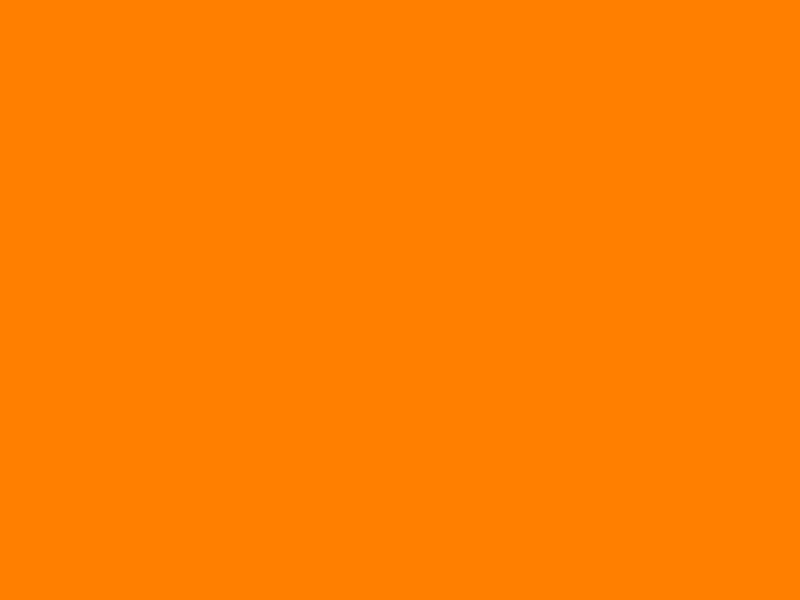

In [220]:
Image(data=download(bucket_name, f"checks/{check_id}/frames/Button-Primary.png"))

In [145]:
Path("data") / button.name

PosixPath('data/Button-Primary.png')

In [204]:
def download(bucket_name, key_name):
    r = s3_client.get_object(Bucket=bucket_name, Key=key_name)
    return r['Body'].read()

In [16]:
def upload(bucket_name, key_name, body):
    return s3_client.put_object(
        Body=body,
        Bucket=bucket_name,
        Key=key_name
    )

In [170]:
def exists(bucket_name, key_name):
    r = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=key_name)
    return "Contents" in r

In [168]:
r = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=results)

In [169]:
r

{'ResponseMetadata': {'RequestId': '45G6QGAXM5SXDNT6',
  'HostId': 'lhtzafLVJNsOp4kz2BUK8n6m8iT6b2yyPIH7qHPDwlhqxh7C6YFNJwU8AQckVn+UHPLW4fxo3Fs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lhtzafLVJNsOp4kz2BUK8n6m8iT6b2yyPIH7qHPDwlhqxh7C6YFNJwU8AQckVn+UHPLW4fxo3Fs=',
   'x-amz-request-id': '45G6QGAXM5SXDNT6',
   'date': 'Fri, 25 Mar 2022 22:31:52 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Contents': [{'Key': 'checks/1644302997171/report/results.json',
   'LastModified': datetime.datetime(2022, 3, 23, 16, 35, 5, tzinfo=tzutc()),
   'ETag': '"6dbcd0b3a1f2cca24eceaa03b6d40629"',
   'Size': 32,
   'StorageClass': 'STANDARD'}],
 'Name': 'same-story',
 'Prefix': 'checks/1644302997171/report/results.json',
 'MaxKeys': 1000,
 'EncodingType': 'url',
 'KeyCount': 1}

In [159]:
results

'checks/testing-source/report/results.json'

In [173]:
exists(bucket_name, results)

False

In [180]:
spec_d = json.loads(download(bucket_name, spec)); spec_d

{'check': '5d76e6cf-abb5-4999-af4f-939776a01d67',
 'width': '800',
 'height': '600',
 'component': 'Button',
 'story': 'Primary',
 'repository': 'engi-network/engi-ui',
 'branch': 'master',
 'commit': '2f513f8411b438f140ddef716ea92d479bc76f81'}

In [275]:
spec_d["branch"] = "master"
spec_d["check"] = test_check_id

In [37]:
spec_d["commit"] = "2f513f8411b438f140ddef716ea92d479bc76f81"

In [32]:
del spec_d["commit"]

In [38]:
r = upload(bucket_name, spec, json.dumps(spec_d)); r

{'ResponseMetadata': {'RequestId': 'XQ8S0ACJX08JPP91',
  'HostId': 'WxfM3tM7iz7VaTwCq2HClL3+GwPZgJOFfdjInolSm50q5p1IEKdl9t3Ytk4MoOa2IgIKJGIJVKo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'WxfM3tM7iz7VaTwCq2HClL3+GwPZgJOFfdjInolSm50q5p1IEKdl9t3Ytk4MoOa2IgIKJGIJVKo=',
   'x-amz-request-id': 'XQ8S0ACJX08JPP91',
   'date': 'Thu, 24 Mar 2022 17:03:30 GMT',
   'x-amz-version-id': 'm7WQaRiQZn2dl_Ptzu63Hw1PlvcAOhhx',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"92f98a6598f44312b81cc1413d39b179"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"92f98a6598f44312b81cc1413d39b179"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'm7WQaRiQZn2dl_Ptzu63Hw1PlvcAOhhx'}

In [188]:
float(json.loads(download(bucket_name, results))["MAE"].split()[0])

3.53067

In [58]:
[d["Key"] for d in r["Contents"]]

['checks/1644192579110/frames/Button-Primary.png',
 'checks/1644192788068/frames/Button-Primary.png',
 'checks/1644192935452/frames/Button-Primary.png',
 'checks/1644193581610/frames/Button-Primary.png',
 'checks/1644193683829/frames/Button-Primary.png',
 'checks/1644195299298/frames/Button-Primary.png',
 'checks/1644195325913/frames/Button-Primary.png',
 'checks/1644195594127/frames/Button-Primary.png',
 'checks/1644195594127/specification.json',
 'checks/1644195818782/frames/Button-Primary.png',
 'checks/1644195818782/specification.json',
 'checks/1644200260072/frames/Button-Primary.png',
 'checks/1644200260072/specification.json',
 'checks/1644200302402/frames/Button-Primary.png',
 'checks/1644200302402/specification.json',
 'checks/1644201159122/frames/Button-Primary.png',
 'checks/1644201159122/specification.json',
 'checks/1644205089210/frames/Button-Primary.png',
 'checks/1644205089210/specification.json',
 'checks/1644205110716/frames/Button-Primary.png',
 'checks/1644205110716

In [19]:
r = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix, Delimiter='/')

In [20]:
r

{'ResponseMetadata': {'RequestId': 'NAJ5EYQDWMNMTJY4',
  'HostId': 'zMfhoWOAXvf+tYkcAQMt6UQVZpkJKYEZ9CHunwlh5IjoVdTYXZA24h9JKWKnvJOxJW0zlRZFtDs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'zMfhoWOAXvf+tYkcAQMt6UQVZpkJKYEZ9CHunwlh5IjoVdTYXZA24h9JKWKnvJOxJW0zlRZFtDs=',
   'x-amz-request-id': 'NAJ5EYQDWMNMTJY4',
   'date': 'Fri, 18 Mar 2022 17:12:02 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Name': 'same-story',
 'Prefix': 'checks/1644302997171',
 'Delimiter': '/',
 'MaxKeys': 1000,
 'CommonPrefixes': [{'Prefix': 'checks/1644302997171/'}],
 'EncodingType': 'url'}

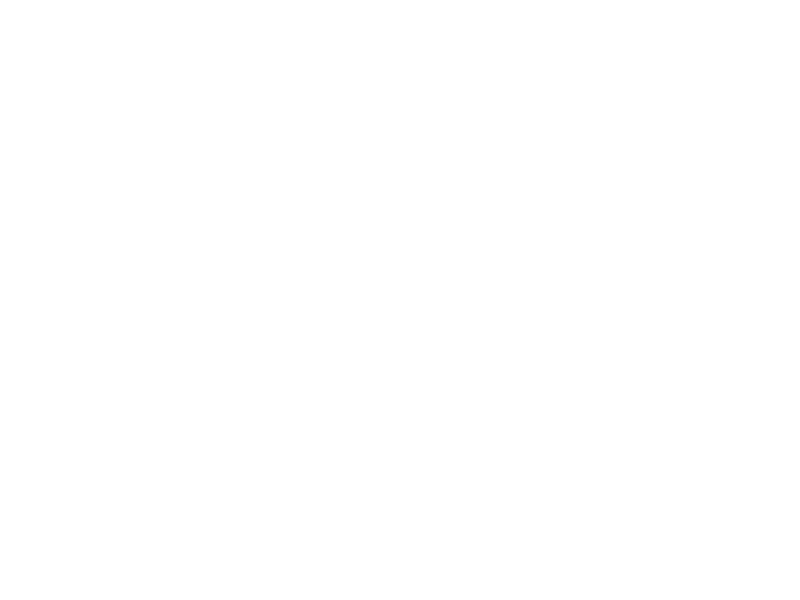

In [212]:
Image(data=download(bucket_name, gray_difference))

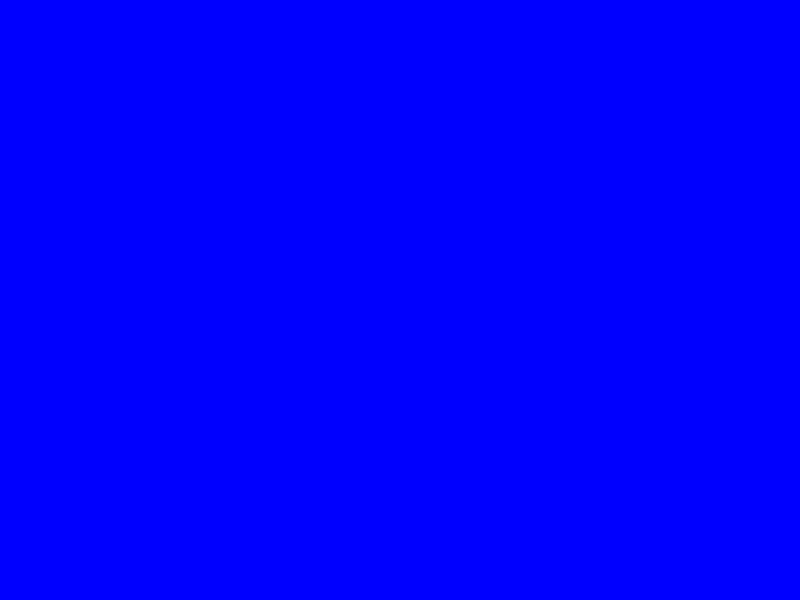

In [213]:
Image(data=download(bucket_name, blue_difference))

In [214]:
json.loads(download(bucket_name, "checks/1644302997171/report/results.json"))

{'MAE': '3.53067 (5.38746e-05)'}

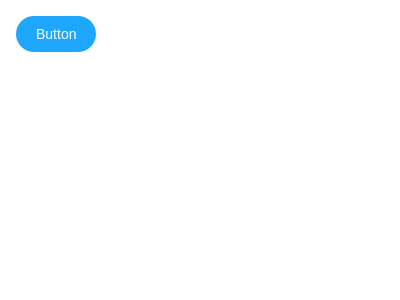

In [56]:
Image(data=download(bucket_name, "checks/1644302997171/report/__screenshots__/Example/Button/Primary.png"))

In [50]:
dirname = f"/tmp/same-story/{prefix}/code"

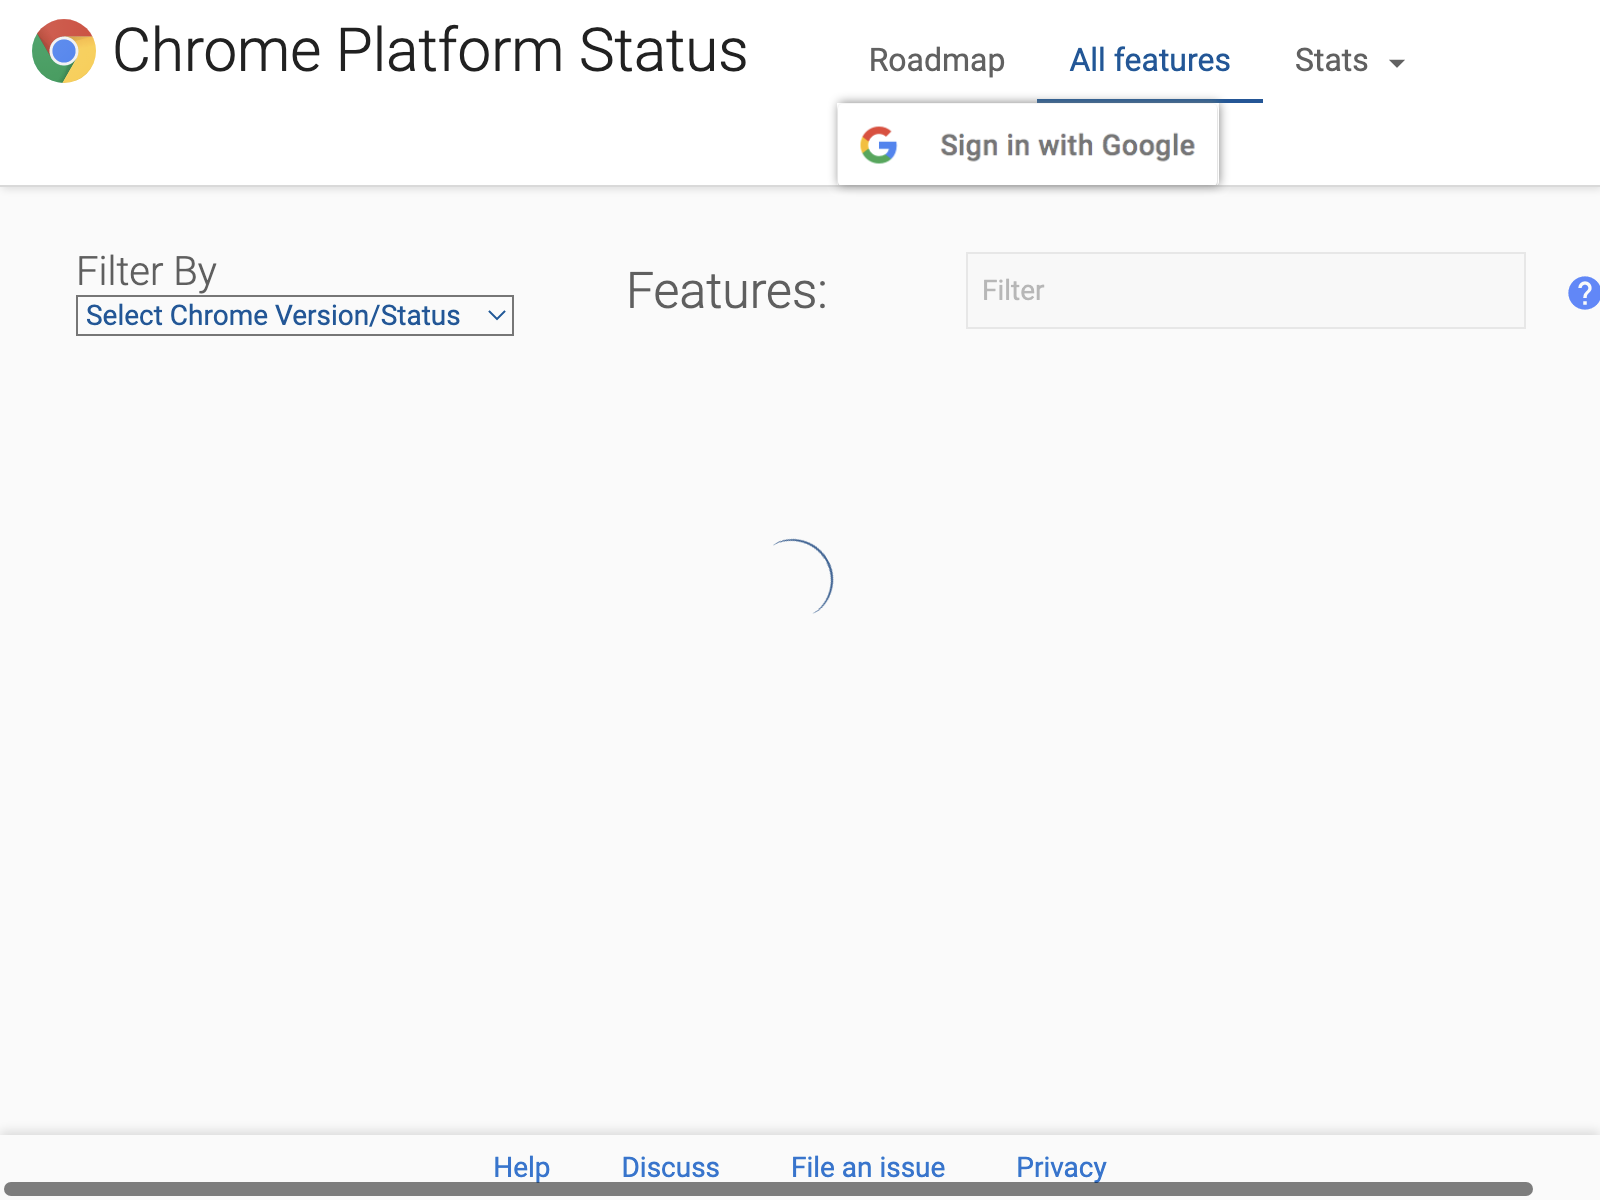

In [51]:
Image(f"{dirname}/screenshot.png")